In [1]:
# import dependencies
import sys
import numpy as np
import pandas as pd

import os
print(os.getcwd())#显示当前路径
os.chdir('D:/bio/STalign/STalign-main')#更改路径，''里面为更改的路径
print(os.getcwd())#显示当前路径

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,10)  # make plots bigger

import torch
if torch.cuda.is_available():
    print('cuda is available')
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')
# import STalign after pip install
from STalign import STalign

D:\bio\jupyter_code\LICA
D:\bio\STalign\STalign-main
cuda is available


The initial shape of V is (2000, 2000, 3)
The range of V is 0.08235294371843338 to 1.0
The range of V after normalization is 0.0 to 1.0
The new shape of J is (3, 2000, 2000)
The initial shape of V is (1904, 2000, 3)
The range of V is 0.08627451211214066 to 1.0
The range of V after normalization is 0.0 to 1.0
The new shape of J is (3, 1904, 2000)


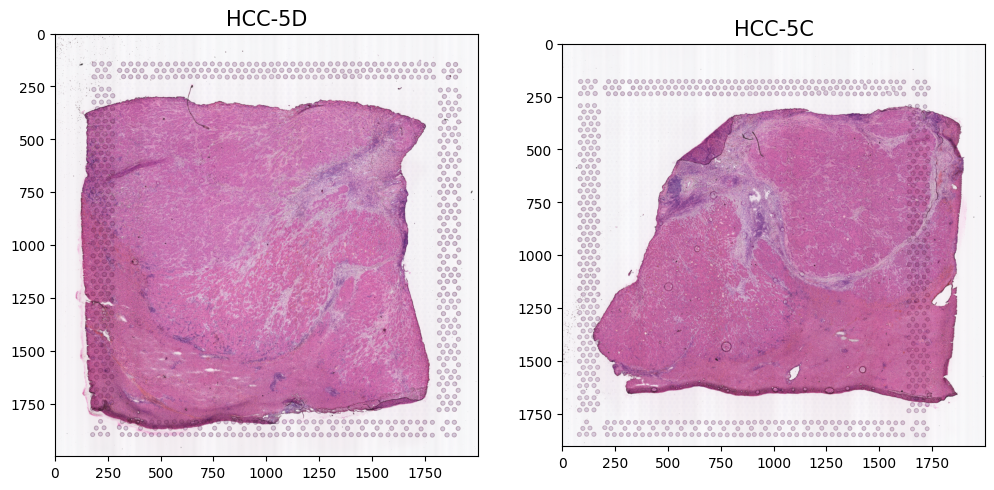

In [2]:
source_dataset = 'HCC-5D'
target_dataset = 'HCC-5C'
input_dir = 'G:/dataset/LICA/input/'
output_dir = 'G:/dataset/LICA/output/STalign/'
image_path = '/spatial/tissue_hires_image.png'
position_path = '/spatial/tissue_positions_list.csv'

datasets = [source_dataset, target_dataset]
image_files = [input_dir+datasets[0]+image_path, input_dir+datasets[1]+image_path]
position_files = [input_dir+datasets[0]+position_path, input_dir+datasets[1]+position_path]
image_datas = []
Xs = []
Ys = []

fig,ax = plt.subplots(1, 2)
for index in range(0, len(datasets)):
    # plot
    V = plt.imread(image_files[index])
    ax[index].imshow(V)
    ax[index].set_title(datasets[index], fontsize=15)
    
    print("The initial shape of V is {}".format(V.shape))
    print("The range of V is {} to {}".format(V.min(), V.max() ))
    Vnorm = STalign.normalize(V)
    print("The range of V after normalization is {} to {}".format(Vnorm.min(), Vnorm.max() ))
    temp = Vnorm.transpose(2,0,1)
    image_datas.append(temp)
    print("The new shape of J is {}".format(temp.shape))
    Xs.append( np.array(range(temp.shape[1]))*1.) # needs to be longs not doubles for STalign.transform later so multiply by 1.
    Ys.append( np.array(range(temp.shape[2]))*1.) # needs to be longs not doubles for STalign.transform later so multiply by 1.


In [3]:
# get cell coordinates
xs = []
ys = []
for index in range(0, len(datasets)):
    df_tmp = pd.read_csv(position_files[index], header = None)
    # 根据输入文件不同需要改变
    xs.append(np.array(df_tmp.iloc[:, 4]))   
    ys.append(np.array(df_tmp.iloc[:, 5]))

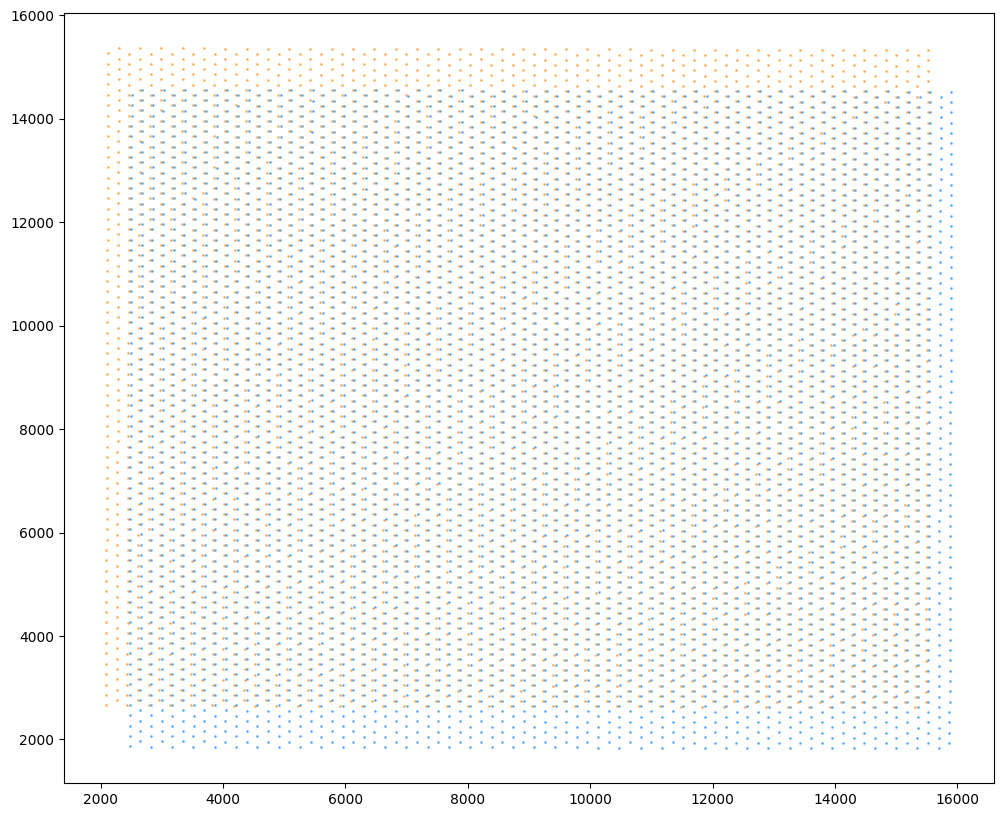

In [4]:
fig,ax = plt.subplots()
ax.scatter(xs[0],ys[0],s=1,alpha=0.5,c='#FF8000')
ax.scatter(xs[1],ys[1],s=1,alpha=0.5,c='#0080FF')

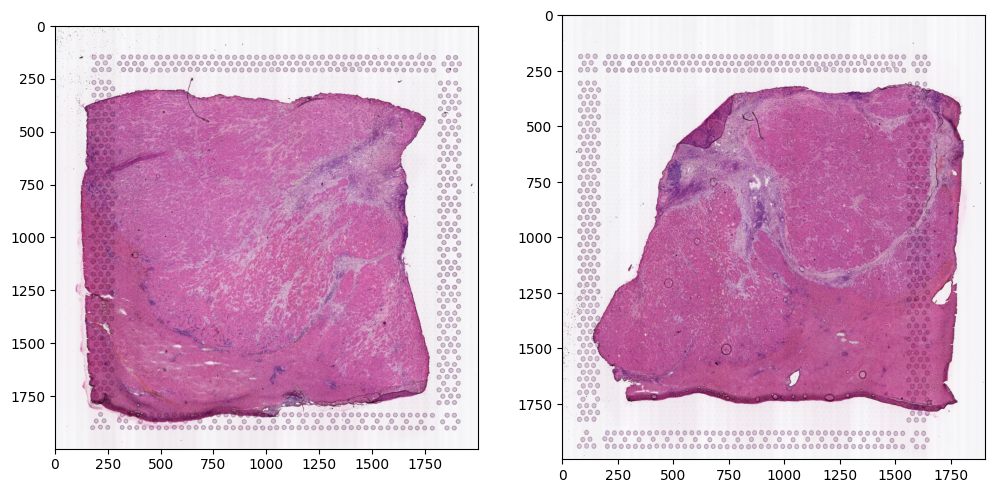

In [5]:
# get extent of images
extent = []
for index in range(0, len(datasets)):
    extent.append(STalign.extent_from_x((Ys[index],Xs[index])))

# plot rasterized images
fig,ax = plt.subplots(1,2)
ax[0].imshow((image_datas[0].transpose(1,2,0).squeeze()), extent=extent[0]) 
ax[1].imshow((image_datas[1].transpose(1,2,0).squeeze()), extent=extent[1])

D:\anaconda\envs\STalign\lib\site-packages\torch\utils\_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
D:\anaconda\envs\STalign\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
D:\bio\STalign\STalign-main\STalign\STalign.py:1280: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


CPU times: total: 9min 49s
Wall time: 7min 11s


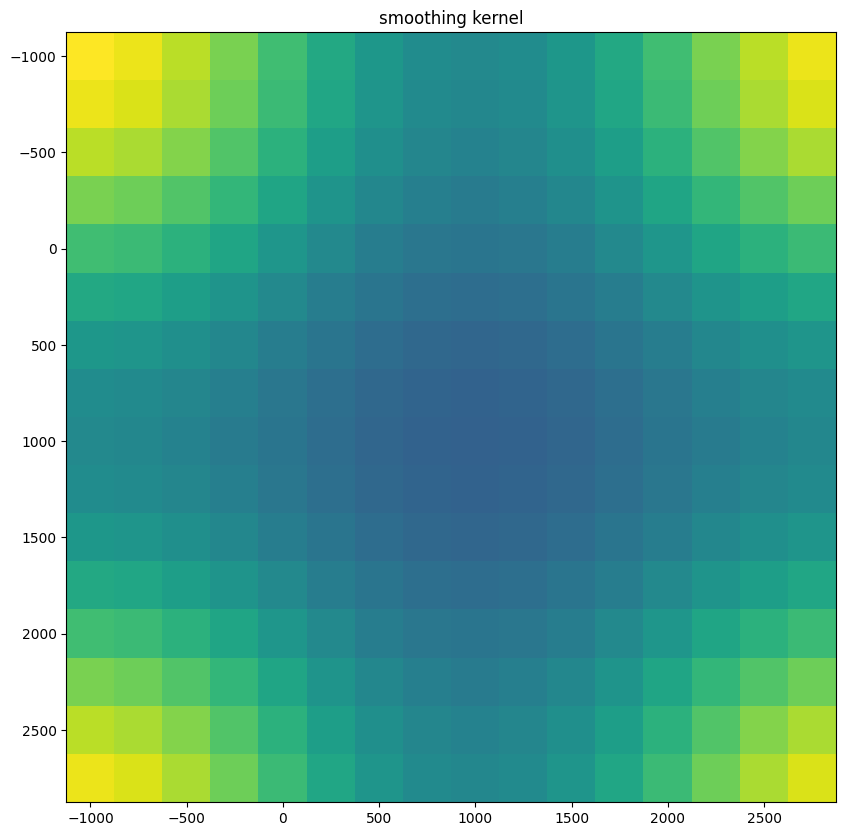

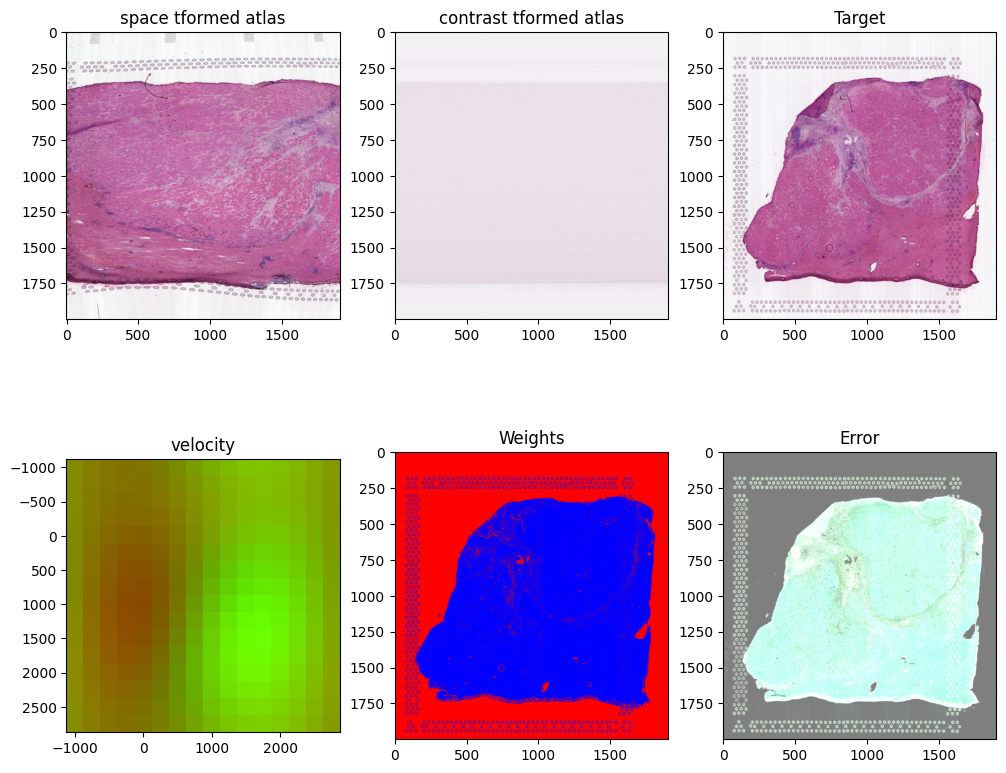

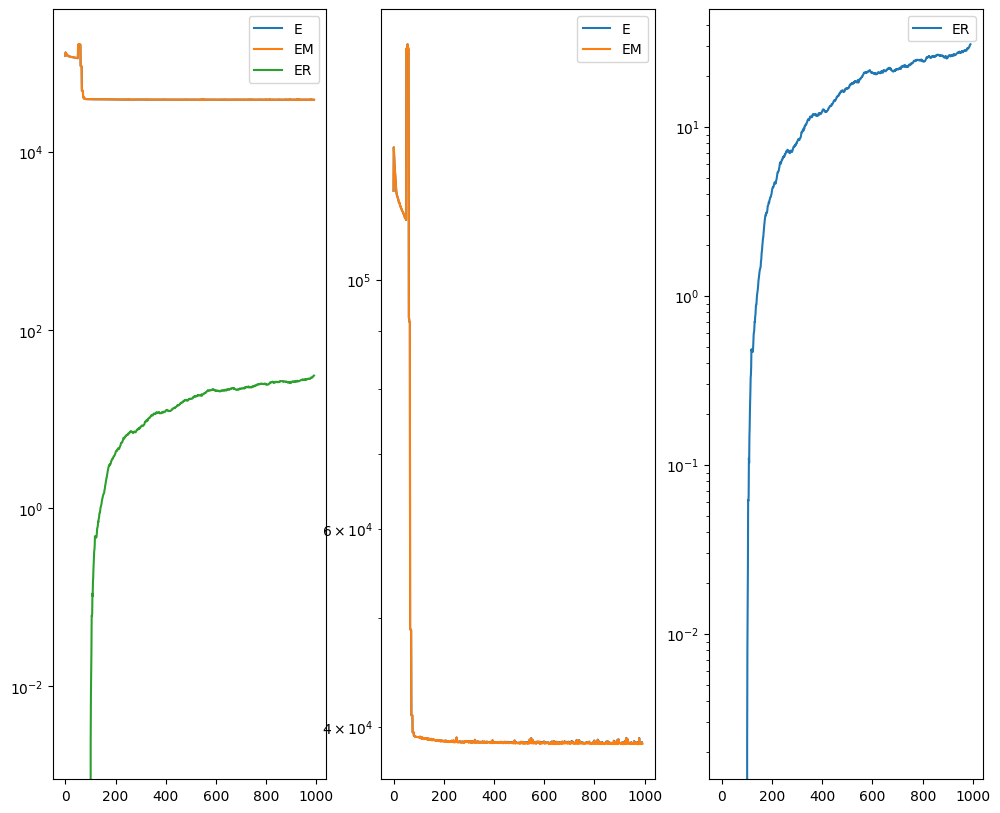

In [6]:
%%time 

# run LDDMM
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
          'niter':1000,
          'device':device,
          'diffeo_start':100,
          'epV':1000,
          'sigmaB':0.1
          }

out = STalign.LDDMM( [Ys[0],Xs[0]], image_datas[0], [Ys[1],Xs[1]], image_datas[1], dtype=torch.float32, **params)

In [7]:
#### get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']
# WM = out['WM']
# WB = out['WM']
# WA = out['WA']

In [ ]:
# apply transform
phii = STalign.build_transform(xv, v, A, XJ=[Ys[1],Xs[1]], direction='b')
phiI = STalign.transform_image_atlas_to_target(xv,v,A,[Ys[0],Xs[0]],image_datas[0],[Ys[1],Xs[1]])

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
if phii.is_cuda:
    ax.contour(Xs[1],Ys[1],phii[...,0].cpu(),colors='r',linestyles='-',levels=levels)
    ax.contour(Xs[1],Ys[1],phii[...,1].cpu(),colors='g',linestyles='-',levels=levels)
else:
    ax.contour(Xs[1],Ys[1],phii[...,0],colors='r',linestyles='-',levels=levels)
    ax.contour(Xs[1],Ys[1],phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')

if phiI.is_cuda:
    ax.imshow(phiI.cpu().permute(1,2,0)/torch.max(phiI.cpu()),extent=extent[1])
else:
    ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extent[1])

In [ ]:
# apply transform to original points
tpointsJ = STalign.transform_points_target_to_atlas(xv,v,A, 
                        np.stack([ list(np.array(ys[1], dtype = 'float32')), list(np.array(xs[1], dtype = 'float32'))], 1))

# just original points for visualizing later
tpointsI = np.stack([xs[0], ys[0]])

# switch from row column coordinates (y,x) to (x,y)
# xI_LDDMM = tpointsI[:,1]
# yI_LDDMM = tpointsI[:,0]

In [ ]:
# plot results
fig,ax = plt.subplots()
if tpointsJ.is_cuda:
    ax.scatter(tpointsI[0,:].cpu(),tpointsI[1,:].cpu(),s=1,alpha=0.1) 
    ax.scatter(tpointsJ[:,1].cpu(),tpointsJ[:,0].cpu(),s=1,alpha=0.2) # also needs to plot as y,x not x,y
else:
    ax.scatter(tpointsI[0,:],tpointsI[1,:],s=1,alpha=0.1) 
    ax.scatter(tpointsJ[:,1],tpointsJ[:,0],s=1,alpha=0.2) # also needs to plot as y,x not x,y

In [ ]:
if tpointsJ.is_cuda:
    df3 = pd.DataFrame(
        {
            "aligned_x": tpointsJ[:,1].cpu(),
            "aligned_y": tpointsJ[:,0].cpu(),
        },
    )
else:
    df3 = pd.DataFrame(
        {
            "aligned_x": tpointsJ[:,1],
            "aligned_y": tpointsJ[:,0],
        },
    )
df1 = pd.read_csv(position_files[0], header = None)
df2 = pd.read_csv(position_files[1], header = None)
results = pd.concat([df2, df3], axis=1)
df1.head()


In [ ]:
results.head()

In [ ]:
results.to_csv(output_dir + source_dataset + '_aligned_to_' + target_dataset + '_HE.csv', sep=',')